# Оптимизация модели LolDetection посредством TensorRT
## Задача:
Применить TensorRT оптимизацию на модель обученную в [тетради TFOD Lol](https://colab.research.google.com/drive/1PoEToTLUVK3YhFczJhITxtBreIfdaj9l?usp=sharing)

## Ожидаемый результат
Обученная модель будет успешно запускать на инференс и будет быстрее работать с оптимизацией, чем без оной.

ЗЫ. Работать оптимизация будет только на GPU. Инференс модели без оптимизации - можно писать на CPU, а оптимизацию мучать уже на GPU.

## План работы:
1. Скачать TFOD Lol модель и запустить ее на инференс.
2. Применить TensorRT к модели в самом простом варианте(чтобы запустилось)
3. Замерить работу с оптимизацией и без оной.

## Загрузка модели для прямого инференса
Просто попробовать ее запустить из сохраненного состояния, после TFOD обучения

In [3]:
%pip install yadisk

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from os import path
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

2022-08-30 20:49:31.288064: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [43]:
paths = {
    'yadisk': {
        'model': 'disk:/my_lol_hd_efficient_det.zip',
        'dataset': 'disk:/lol_detection_hd.zip',
        'test_pic': 'disk:/random_lol_pic.jpg',
    },
    'model_dir': 'my_lol_hd_efficient_det',
    'labels': 'labels.txt',
}

APP_ID = '3687eb507b9a4e2f98c9f9ef624665da'
APP_SECRET = '317bac736f9f488ba40e3048320f9e2e'

## Подключаюсь к Яндекс Диску и скачиваю необходимое для работы

In [6]:
import sys
import yadisk

y = yadisk.YaDisk(APP_ID, APP_SECRET)
url = y.get_code_url()

print("Go to the following url: %s" % url)
code = input("Enter the confirmation code: ")

try:
    response = y.get_token(code)
except yadisk.exceptions.BadRequestError:
    print("Bad code")
    sys.exit(1)

y.token = response.access_token

if y.check_token():
    print("Sucessfully received token!")
else:
    print("Something went wrong. Not sure how though...")

Enter the confirmation code:  1926744
Go to the following url: https://oauth.yandex.ru/authorize?response_type=code&client_id=3687eb507b9a4e2f98c9f9ef624665da&display=popup&force_confirm=yes
Sucessfully received token!


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: y
  warnings.warn(message)


In [42]:
for download_path in paths['yadisk'].values():
    y.download(download_path, path.basename(download_path))

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: y
  warnings.warn(message)


#### Подгружаю labels

In [37]:
!unzip -o 'lol_detection_hd.zip' labels.txt

Archive:  lol_detection_hd.zip
  inflating: labels.txt              


In [38]:
category_index = []
with open('labels.txt') as f:
  category_index = { id: { 'id': id, 'name': item.strip()} for id, item in enumerate(f.readlines())}

del category_index[0]
category_index

{1: {'id': 1, 'name': 'renekton'},
 2: {'id': 2, 'name': 'gwen'},
 3: {'id': 3, 'name': 'jarvan4'},
 4: {'id': 4, 'name': 'aphelios'},
 5: {'id': 5, 'name': 'le blanc'},
 6: {'id': 6, 'name': 'lissandra'},
 7: {'id': 7, 'name': 'braum'},
 8: {'id': 8, 'name': 'panteon'},
 9: {'id': 9, 'name': 'samira'},
 10: {'id': 10, 'name': 'rell'}}

## Загружаю модель(в формате `saved_model`)

In [40]:
!unzip -o 'my_lol_hd_efficient_det.zip'

Archive:  my_lol_hd_efficient_det.zip
   creating: my_lol_hd_efficient_det/
   creating: my_lol_hd_efficient_det/checkpoint/
  inflating: my_lol_hd_efficient_det/checkpoint/checkpoint  
  inflating: my_lol_hd_efficient_det/checkpoint/ckpt-0.data-00000-of-00001  
  inflating: my_lol_hd_efficient_det/checkpoint/ckpt-0.index  
  inflating: my_lol_hd_efficient_det/pipeline.config  
   creating: my_lol_hd_efficient_det/saved_model/
   creating: my_lol_hd_efficient_det/saved_model/assets/
  inflating: my_lol_hd_efficient_det/saved_model/saved_model.pb  
   creating: my_lol_hd_efficient_det/saved_model/variables/
  inflating: my_lol_hd_efficient_det/saved_model/variables/variables.data-00000-of-00001  
  inflating: my_lol_hd_efficient_det/saved_model/variables/variables.index  


In [91]:
#!g1.1
model = tf.saved_model.load(path.join(paths['model_dir'], 'saved_model'))

2022-09-01 22:22:28.525217: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-01 22:22:47.713985: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-01 22:22:51.842228: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-09-01 22:22:51.849023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci 

#### Инференс модели

In [46]:
import PIL

from PIL import Image, ImageDraw, ImageFont

## ГИГАВАЖНЫЙ МОМЕНТ
Для инференса - думал как подгрузить картинку.  
В тетрадке, в которой обучал модель(по гайду!) для загрузки изображения используется `cv2`  
Т.к. огромную библиотеку не хотелось грузить для простой загрузки картинок - я загрузил через `PIL`.

При инференсе - детекций не было(я перепутал ширину с высотой при загрузки из PIL) и я в ходе разбирательств СЛУЧАЙНО нашел, что **вариант в котором грузит картинку cv2 - BGR, а не RGB!**.  
**При этом модель обучалась на RGB варианте**(так заливалась в tfrecord).  
Т.е. в гайде по TFOD, что я взял за основу - ошибка, которая напрямую влияет на качество модели.

Как оказалось, моя модель обученная(при этом, я ее всего 10000 шагов обучал, и закончил не на лучшем результате) не только умеет правильно определять огранич. прямоугольники, но и классы персонажей!  
Из 6 -> 6 правильно!


In [49]:
img = Image.open(path.basename(paths['yadisk']['test_pic']))
image_np = np.array(img)
img_arr = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)
img_arr.shape

2022-08-30 21:33:39.617162: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-30 21:33:51.868839: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-30 21:33:51.868880: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 21:33:51.868906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-0235044b-3104-4474-9032-ff258fef5120): /proc/driver/nvidia/version does not exist
2022-0

TensorShape([1, 1079, 1919, 3])

In [52]:
#!g1.1
detections = model(img_arr)
detections.keys()

dict_keys(['detection_classes', 'detection_multiclass_scores', 'raw_detection_scores', 'num_detections', 'raw_detection_boxes', 'detection_boxes', 'detection_scores', 'detection_anchor_indices'])

2022-08-30 21:36:15.123406: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: model
  warnings.warn(message)


Оно что то задетектировало! о:<  
Осталось как то вывести ограничивающие квадратики, не затягивая с собой всю библиотеку `object_detection`

Реализую руками функцию реализующую вывод BB с подписями.  
И чтобы библиотеку не тащить и просто чтобы написать свою функцию

2022-08-30 21:37:34.467911: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-30 21:37:47.183273: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-30 21:37:47.183316: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 21:37:47.183340: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-0235044b-3104-4474-9032-ff258fef5120): /proc/driver/nvidia/version does not exist
2022-0

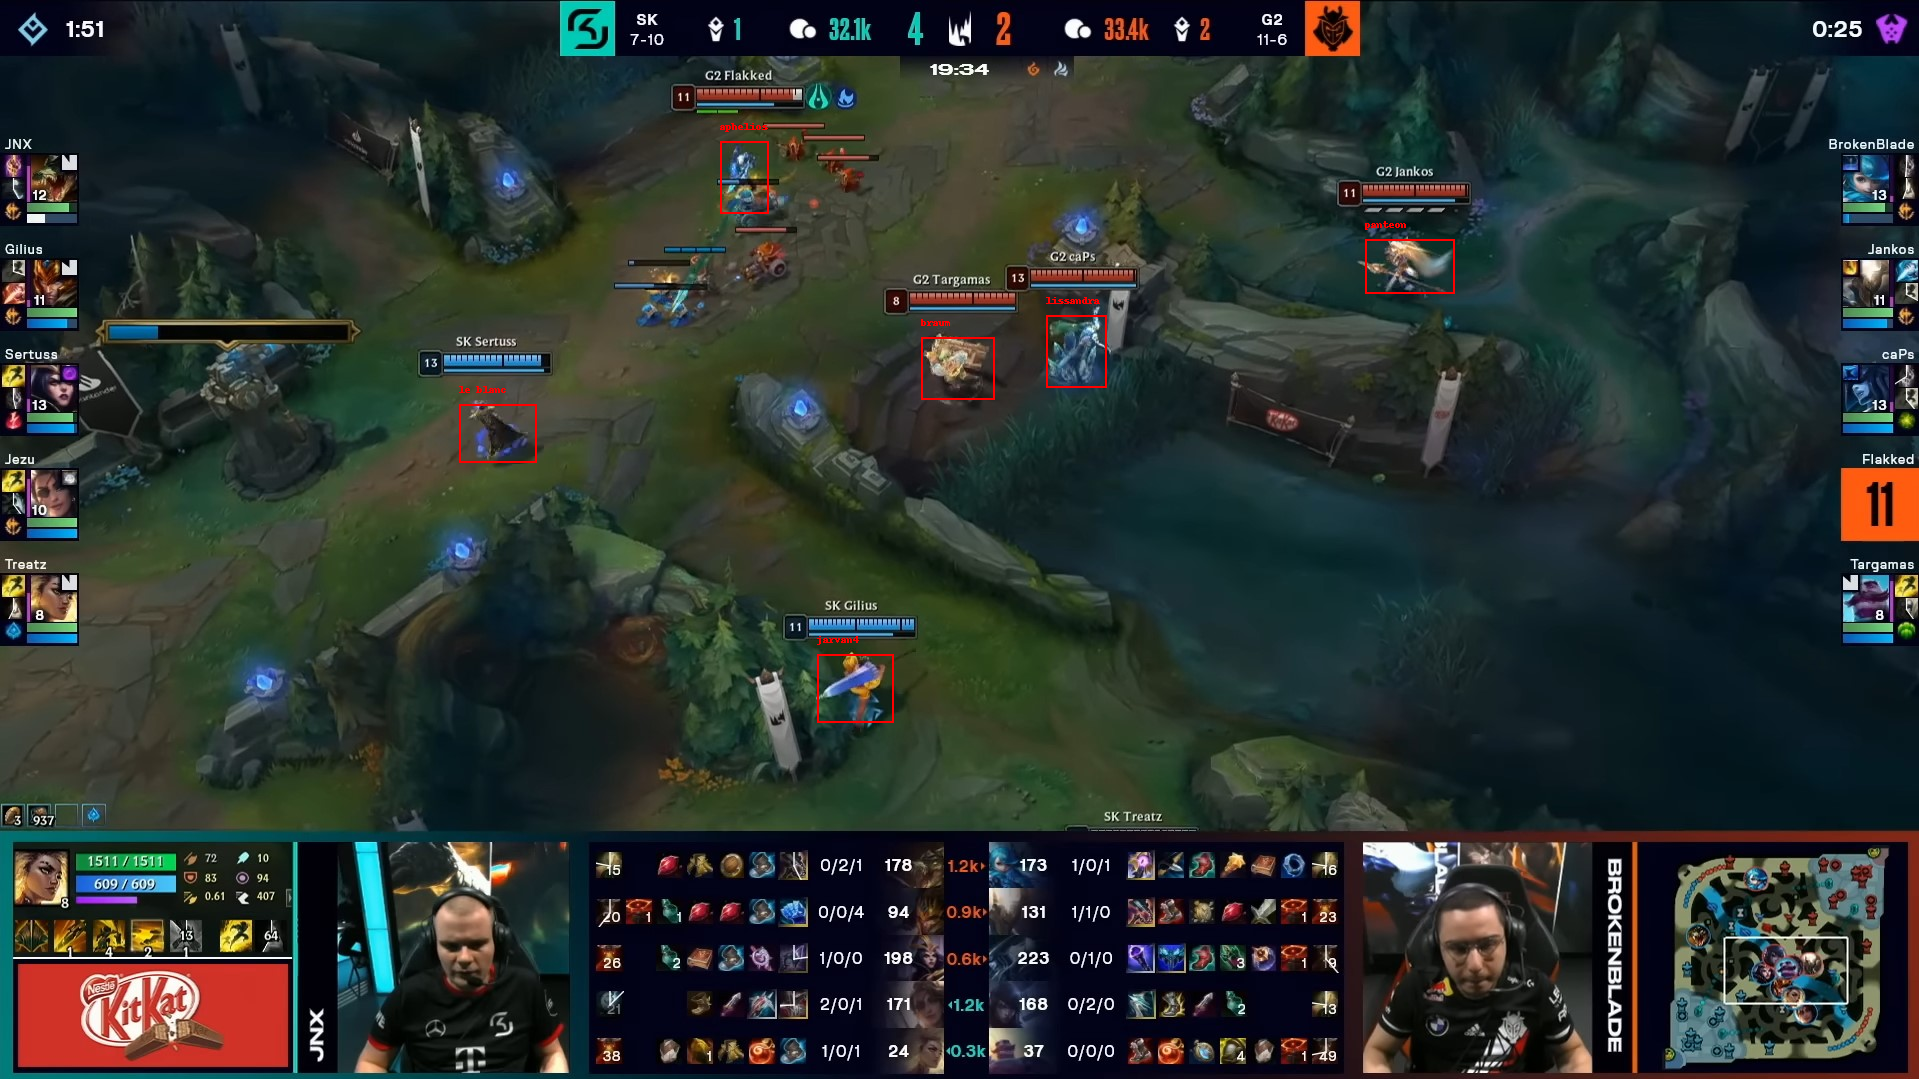

In [54]:
def show_bb(img_src, img_size, detections, min_score_thresh):
  img_draw = ImageDraw.Draw(img_src)

  num_detections = int(detections['num_detections'].numpy()[0])
  for i in range(num_detections):
    if detections['detection_scores'][0, i].numpy() < min_score_thresh:
      break
    
    y0, x0, y1, x1 = detections['detection_boxes'][0, i].numpy()
    x0, y0, x1, y1 = x0 * 1920, y0 * 1080, x1 * 1920, y1 * 1080
    img_draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
    font = ImageFont.load_default()
    cat_id = int(detections['detection_classes'][0, i].numpy())
    # TODO размер букв увеличить(и другой шрифт может быть взять)
    img_draw.text((x0, y0 - 20), category_index[cat_id]['name'], fill='red', font=font)

  return img_src


min_score_thresh = 0.3
img_src = Image.open(path.basename(paths['yadisk']['test_pic']))
show_bb(img_src, (img_src.size[0], img_src.size[1]), detections, min_score_thresh)

Собственно реализовал c:

## TF-TRT
Попытка создать trt engine через TensorRT имплементацию в TF. (неудачно :<)

In [56]:
#!g1.1
from tensorflow.python.compiler.tensorrt import trt_convert as trt
converter = trt.TrtGraphConverterV2(input_saved_model_dir=path.join(paths['model_dir'], 'saved_model'))
converter.convert()
converter.save(path.join(paths['model_dir'], 'tf_trt'))

INFO:tensorflow:Linked TensorRT version: (8, 4, 2)
INFO:tensorflow:Loaded TensorRT version: (8, 4, 2)
INFO:tensorflow:Clearing prior device assignments in loaded saved model
INFO:tensorflow:Automatic mixed precision has been deactivated.


ValueError: Received a shape scalar with unknown static value.  A static value of '-1' is required to represent an unknown shape.

2022-08-30 21:42:39.503849: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-30 21:42:52.399275: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 21:42:55.781513: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-08-30 21:42:55.785103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci 

Через TF-TRT оно не смогло создать engine.  
При этом, с простой моделью - оно может справиться.

## Создание TensorRT Engine(по спец. гайду для EfficientDet)

Пришлось следовать по пайплайну: TF SavedModel -> ONNX -> TensorRT Engine

По гайдам которые я нашел, выяснилось, что EfficientDet и TensorRT не особо дружат и что требуется использовать некоторые махинации, чтобы они вместе могли работать.

Мне этот репозиторий не то, чтобы был очень нужен, скорее чтобы удобнее подсматривать было(репозиторий EfficientDet)

In [68]:
!git clone https://github.com/google/automl
%cd automl
!git checkout 0b0ba5e

/home/jupyter/work/resources/automl


Cloning into 'automl'...
Note: switching to '0b0ba5e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 0b0ba5e change urls


### Конвертация модели


In [76]:
%pip install pip onnx
%pip install onnx-graphsurgeon --index-url https://pypi.ngc.nvidia.com
%pip install tf2onnx
%pip install onnxruntime
%pip install pycuda

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 22.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-war

In [72]:
!git clone https://github.com/NVIDIA/TensorRT.git

Cloning into 'TensorRT'...
Updating files: 100% (1734/1734), done.


In [77]:
#!g1.1
!python3 TensorRT/samples/python/efficientdet/create_onnx.py \
    --input_size 1024,1024 \
    --saved_model my_lol_hd_efficient_det/saved_model \
    --onnx onnx_model.onnx

2022-08-31 08:22:42.600855: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-31 08:22:54.960758: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 08:22:58.555282: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-08-31 08:22:58.559375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci 

In [ ]:
#!g1.1
!python3 TensorRT/samples/python/efficientdet/build_engine.py \
    --onnx=onnx_model.onnx \
    --engine=trt_model_engine.trt \
    --precision fp16

In [85]:
#!g1.1
!python3 TensorRT/samples/python/efficientdet/infer.py \
    --engine trt_model_engine.trt \
    --input random_lol_pic.jpg \
    --output out_res/ \
    --nms_threshold 0.35 \
    --labels labels.txt

Input 'input' with shape [1, 1024, 1024, 3] and dtype float32
Output 'num_detections' with shape [1, 1] and dtype int32
Output 'detection_boxes' with shape [1, 100, 4] and dtype float32
Output 'detection_scores' with shape [1, 100] and dtype float32
Output 'detection_classes' with shape [1, 100] and dtype int32
Inferring data in random_lol_pic.jpg
Processing Image 1 / 1
Finished Processing


## Инференс TensorRT Engine моей модели детекции


In [94]:
#!g1.1
!python3 TensorRT/samples/python/efficientdet/infer.py \
    --engine trt_model_engine.trt \
    --input random_lol_pic.jpg \
    --output out_res/ \
    --nms_threshold 0.35 \
    --labels labels.txt

Input 'input' with shape [1, 1024, 1024, 3] and dtype float32
Output 'num_detections' with shape [1, 1] and dtype int32
Output 'detection_boxes' with shape [1, 100, 4] and dtype float32
Output 'detection_scores' with shape [1, 100] and dtype float32
Output 'detection_classes' with shape [1, 100] and dtype int32
Inferring data in random_lol_pic.jpg
Processing Image 1 / 1
Finished Processing


Результат инференса trt engine:

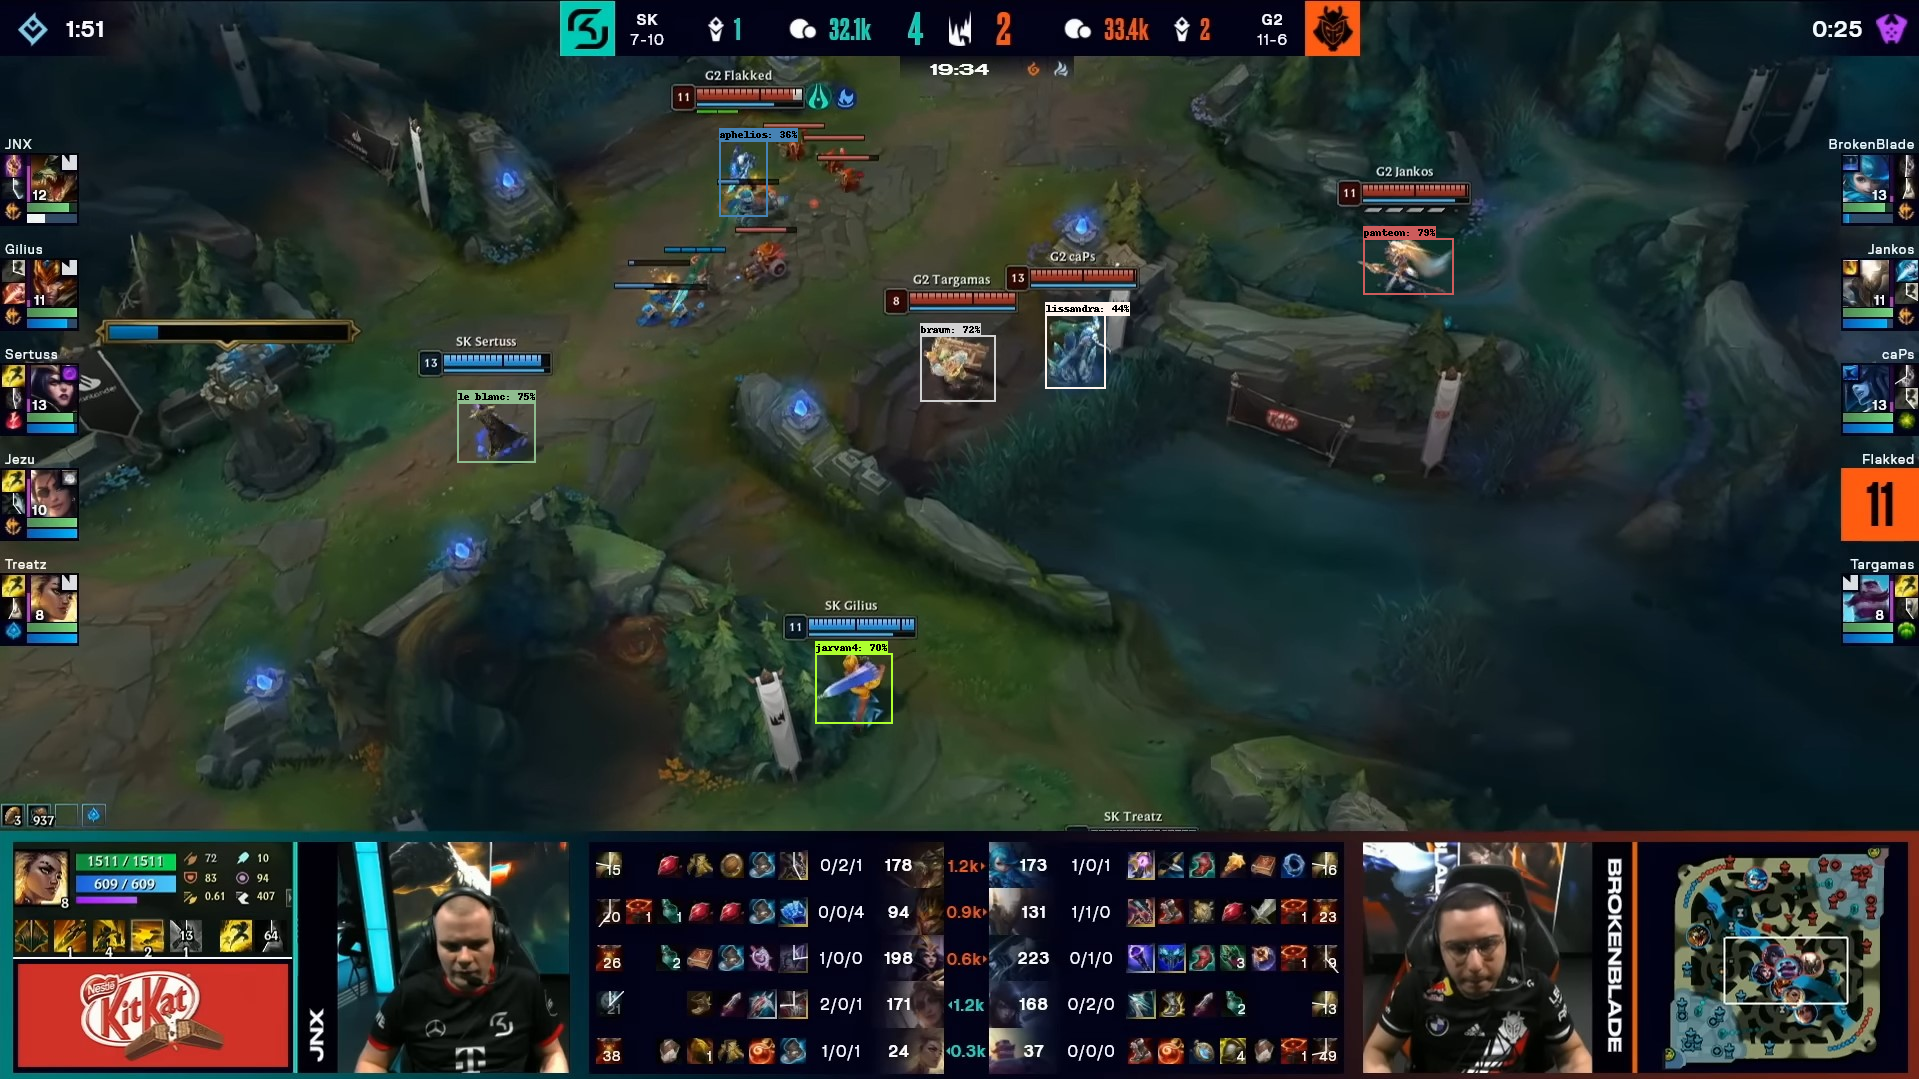

In [95]:
Image.open('out_res/random_lol_pic.png')

## Сравниваю скорости работы без оптимизации и с оной

Для этого запускаю trt engine(точнее утилку для работы с ней) в benchmark моде. Labels и output приходится указывать, т.к. разработчик забыл добавить проверки "передано ли \*" и без этих параметров код падает x_x

In [92]:
#!g1.1
!python3 TensorRT/samples/python/efficientdet/infer.py \
    --engine trt_model_engine.trt \
    --output out_res/ \
    --labels labels.txt

Input 'input' with shape [1, 1024, 1024, 3] and dtype float32
Output 'num_detections' with shape [1, 1] and dtype int32
Output 'detection_boxes' with shape [1, 100, 4] and dtype float32
Output 'detection_scores' with shape [1, 100] and dtype float32
Output 'detection_classes' with shape [1, 100] and dtype int32
No input provided, running in benchmark mode
batch size (1, 1024, 1024, 3)
Benchmark results include time for H2D and D2H memory copies
Average Latency: 21.744 ms
Average Throughput: 46.0 ips

Finished Processing


In [93]:
#!g1.1
%%timeit -r 200
detections = model(img_arr)

2022-09-01 22:35:25.676522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


101 ms ± 5.35 ms per loop (mean ± std. dev. of 200 runs, 1 loop each)


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: model
  warnings.warn(message)


Шок, разница в скорости инференса 5 раз!  
Т.е. применение TensorRT(в т.ч. и с EfficientDet моделями, где нет "работы из коробки") более чем оправдано.
